<a href="https://www.kaggle.com/code/diaconumadalina/bbc-text-classification-1-text-preprocessing?scriptVersionId=155923263" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## 1 Beginning



### 1.1 Problem

We are dealing with a traditional supervised document classification challenge, where a substantial number of text files have already been sorted into their corresponding categories.

#### Dataset

- Data consists of 2225 documents from the BBC news website corresponding to stories in five topical areas from 2004-2005.
- Natural Classes: 5 (business, entertainment, politics, sport, tech)

> All rights, including copyright, in the content of the original articles are owned by the BBC.
D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006.

### 1.2 Solution

Construct a Neural Network for the purpose of categorizing documents according to their textual content. 

The Document Classification task is segmented into two key phases:

1. Step 1 - Preprocessing:

    - Refine and condense the textual content in files by eliminating redundant spaces and newlines.
    - Utilize [spaCy][1] for language processing.

2. Step 2 - Modeling:

    - Use a [neural network architecture][2] for this specific solution.
    - Visualize and graph performance metrics.

[1]: https://spacy.io/api/ 
[2]: https://www.kaggle.com/code/dheemanthbhat/bbc-text-classification-part-2-modeling

### 1.3 Project structure

Project: BBC Full Text Document Classification

- **code:**
  - BBC Document Classification Part 1 - Preprocessing.ipynb
  - BBC Document Classification Part 2 - Modeling.ipynb

- **input:**
  - **bbc-full-text-document-classification:**
    - README.TXT
    - **business:**
      - 001.txt, 002.txt, ..., (Total 510 files)
    - **entertainment:**
      - 001.txt, 002.txt, ..., (Total 386 files)
    - **politics:**
      - 001.txt, 002.txt, ..., (Total 417 files)
    - **sport:**
      - 001.txt, 002.txt, ..., (Total 511 files)
    - **tech:**
      - 001.txt, 002.txt, ..., (Total 401 files)

  - **bbc-text-preprocessed:**
    - docs_stage_1_metadata.csv
    - docs_stage_2_parsed_text.csv
    - docs_stage_3_preprocessed.csv

  - **glove-global-vectors-for-word-representation:**
    - glove.6B.100d.txt

- **logs:**
  - **train**
  - **validation**

- **models:**
  - epoch-01_accuracy-0.2520.hdf5
  - ...
  - epoch-13_accuracy-0.9718.hdf5


<!-- 
BBC Full Text Document Classification
    ├───code
    │       BBC Document Classification Part 1 - Preprocessing.ipynb
    │       BBC Document Classification Part 2 - Modeling.ipynb
    │
    ├───input
    │   ├───bbc-full-text-document-classification
    │   │   └───bbc
    │   │       │   README.TXT
    │   │       ├───business
    │   │       │       001.txt
    │   │       │       002.txt
    │   │       │       ...                          (Total 510 files)
    │   │       ├───entertainment
    │   │       │       001.txt
    │   │       │       002.txt
    │   │       │       ...                          (Total 386 files)
    │   │       ├───politics
    │   │       │       001.txt
    │   │       │       002.txt
    │   │       │       ...                          (Total 417 files)
    │   │       ├───sport
    │   │       │       001.txt
    │   │       │       002.txt
    │   │       │       ...                          (Total 511 files)
    │   │       └───tech
    │   │               001.txt
    │   │               002.txt
    │   │               ...                          (Total 401 files)
    │   │
    │   ├───bbc-text-preprocessed
    │   │       docs_stage_1_metadata.csv
    │   │       docs_stage_2_parsed_text.csv
    │   │       docs_stage_3_preprocessed.csv
    │   │
    │   └───glove-global-vectors-for-word-representation
    │           glove.6B.100d.txt
    │
    ├───logs
    │   ├───train
    │   └───validation
    │
    └───models
            epoch-01_accuracy-0.2520.hdf5
            ...
            epoch-13_accuracy-0.9718.hdf5
 -->

## 2 Setup

### 2.1 Import and configure libraries

In [1]:
# Data manipulation libraries
import numpy as np
import pandas as pd
import spacy

# Data visualization libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

# General Imports
import os
import re
from tqdm import tqdm
from colorama import Fore, Style

#text processing and cleaning
import unicodedata
import re

# Library versions
print("Numpy version:", np.__version__)
print("Spacy version:", spacy.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)

# Configure Numpy
# specify that the maximum width of printed lines should be 130 characters
# after 130 characters it will continue in the next line
np.set_printoptions(linewidth=130)

# Configure Seaborn
sns.set_style("whitegrid") # set white background with grid
sns.set_palette("deep") # set color palette
sns.set_context("paper", font_scale=1.25) # set font to scale 1.25 , greater than default

Numpy version: 1.24.3
Spacy version: 3.7.2
Pandas version: 2.0.3
Matplotlib version: 3.7.4
Seaborn version: 0.12.2


### 2.2 Constants and helper functions

#### Constants

In [2]:
DOCS_DIR = "/kaggle/input/bbc-full-text-document-classification/bbc"
METADATA_CSV = "/kaggle/working/docs_stage_1_metadata.csv"
PARSED_TEXT_CSV = "/kaggle/working/docs_stage_2_parsed_text.csv"

#### Helper functions

In [31]:
def get_duplicate_doc_ids(df):
    """
    Retrieve a list of document ids that appear more than once in the dataset.
    """
    duplicate_doc_ids = [doc_id for doc_id, count in df["DocId"].value_counts().items() if count > 1]
    return duplicate_doc_ids

def get_corr_mat(df, target):
    """
    Function to return:
        Returns a correlation matrix sorted by the specified target variable in descending order,
    with the variance of each variable reset to zero.
    """

    # Calculate the correlation matrix
    corr_mat = df.corr()

    # Reset the diagonal elements (variance) to zero
    corr_mat.values[np.eye(corr_mat.shape[0], dtype=bool)] = 0

    # Sort the correlation matrix by the target variable in descending order
    sorted_corr_mat = corr_mat.sort_values(by=target, ascending=False)

    return sorted_corr_mat

# def get_corr_mat(df, target):
#     """
#     Function to return:
#         1. Correlation matrix sorted by target value in descending order.
#         2. Variance of random variables reset to zero.
#     """
#     # Select only numeric columns for correlation calculation
#     numeric_df = df.select_dtypes(include=[np.number])

#     # Calculate the correlation matrix
#     corr_mat = numeric_df.corr()

#     # Reset the diagonal elements (variance) to zero
#     np.fill_diagonal(corr_mat.values, 0)

#     # Sort the correlation matrix by the target variable in descending order
#     sorted_corr_mat = corr_mat[target].sort_values(ascending=False)

#     return sorted_corr_mat

#### Plotting functions

In [4]:
def plot_percentile_range(lower_limit, upper_limit, column_name, dataframe, y_label):
    """
    Plot the values of a column within a specified percentile range.

    Parameters:
    - lower_limit: float, lower percentile limit
    - upper_limit: float, upper percentile limit
    - column_name: str, the name of the column in the DataFrame
    - dataframe: DataFrame, the input DataFrame
    - y_label: str, label for the y-axis
    """
    plt.figure(figsize=(4, 3))

    # Corrected percentiles to be in the range [0, 1]
    percentiles = np.arange(lower_limit / 100, upper_limit / 100, 0.01)
    values = dataframe[column_name].quantile(q=percentiles)

    sns.lineplot(x=percentiles * 100, y=values)  # Multiply by 100 for proper x-axis labeling
    plt.title(f"{y_label} between {lower_limit}% and {round(upper_limit - 0.01, 2)}% percentile")
    plt.xlabel("Percentile")
    plt.ylabel(y_label)

    plt.show()

# # Example usage
# plot_percentile_range(10, 90, "FileSize", meta_df, "File size in Bytes")


### 2.3 Metadata

Extract and save metadata from document files. Meta data like:

1. **Document type:** Class-label taken from folder name containing documents.
2. **Document Id:** Generated using first character from document type and file name. Example: *B_101*.
3. **File size:** File size in bytes.
4. **File path:** Relative file path.

In [5]:
# This version uses list comprehensions for more concise list creation

if os.path.exists(METADATA_CSV): # Checking for Existing Metadata File: This part checks if a CSV file named METADATA_CSV (presumably a constant containing the file path) exists.
    print("Loading metadata from:", METADATA_CSV)
    meta_df = pd.read_csv(METADATA_CSV)  # If it does, the metadata is loaded into a Pandas DataFrame (meta_df) using pd.read_csv().
else: 
    meta_data = [ #If the metadata file doesn't exist, it creates a list called meta_data using a list comprehension.
        [dir_name.capitalize(), 
         f"{dir_name[0].upper()}_{os.path.splitext(file_name)[0]}", 
         os.path.getsize(os.path.join(DOCS_DIR, dir_name, file_name)), 
         os.path.join(DOCS_DIR, dir_name, file_name)]
        for dir_name in os.listdir(DOCS_DIR) if os.path.isdir(os.path.join(DOCS_DIR, dir_name))
        for file_name in os.listdir(os.path.join(DOCS_DIR, dir_name))
    ]
# The list comprehension iterates over directories and files in the specified DOCS_DIR. It constructs a list for each file with information such as DocType, DocId, FileSize, and FilePath.
    col_names = ["DocType", "DocId", "FileSize", "FilePath"]
    meta_df = pd.DataFrame(meta_data, columns=col_names)
    meta_df.to_csv(METADATA_CSV, index=False, na_rep="") # if there are any missing values in the DataFrame, they will be represented as empty strings in the CSV file.
#     When set to False, the CSV file won't have an additional column for the index.
    print("Metadata saved to:", METADATA_CSV)
# After collecting metadata, it creates a Pandas DataFrame (meta_df) from meta_data and saves it to the CSV file using to_csv().
meta_df["DocType"] = meta_df["DocType"].astype("category")
# Converts the "DocType" column in the DataFrame to a categorical data type.

meta_df.sample(3)


Metadata saved to: /kaggle/working/docs_stage_1_metadata.csv


,DocType,DocId,FileSize,FilePath
910,Sport,S_340,2608,/kaggle/input/bbc-full-text-document-classific...
1122,Tech,T_006,3931,/kaggle/input/bbc-full-text-document-classific...
2195,Business,B_444,1692,/kaggle/input/bbc-full-text-document-classific...


## 3 EDA (Document Metadata)

In [6]:
rows, cols = meta_df.shape
print(f"Dataset contains {rows} rows and {cols} columns.\n")
      
meta_df.info()

# when you see "object" as the data type in a Pandas DataFrame column, it typically implies that the column contains non-numeric data, such as strings or a mix of different types. 
# In this specific case, "FilePath" likely contains string values representing file paths.

Dataset contains 2225 rows and 4 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   DocType   2225 non-null   category
 1   DocId     2225 non-null   object  
 2   FileSize  2225 non-null   int64   
 3   FilePath  2225 non-null   object  
dtypes: category(1), int64(1), object(2)
memory usage: 54.7+ KB


#### Remarks :

The dataset contains complete information, with every column having values specified for each corresponding entry, ensuring there are **no instances of missing data** across the entire dataset.

### 3.1 Duplicates Check

#### Verify if there are any instances of duplicate 'DocIds' within each category in the dataset

In [7]:
dup_doc_ids = get_duplicate_doc_ids(meta_df)
print(len(dup_doc_ids), "`DocIds` appear more than once in the dataset.")

0 `DocIds` appear more than once in the dataset.


### 3.2 Class-label: `DocType`

In [8]:
import pandas as pd

# Calculate class counts
cls_count = meta_df["DocType"].value_counts()
# print(cls_count)
# Create a DataFrame from the value counts
cls_count_df = pd.DataFrame({"Class label": cls_count.index, "Count": cls_count.values})

# Add a column for serial numbers
cls_count_df["Serial No"] = cls_count_df.index + 1

# Display the DataFrame
print(cls_count_df)


     Class label  Count  Serial No
0          Sport    511          1
1       Business    510          2
2       Politics    417          3
3           Tech    401          4
4  Entertainment    386          5


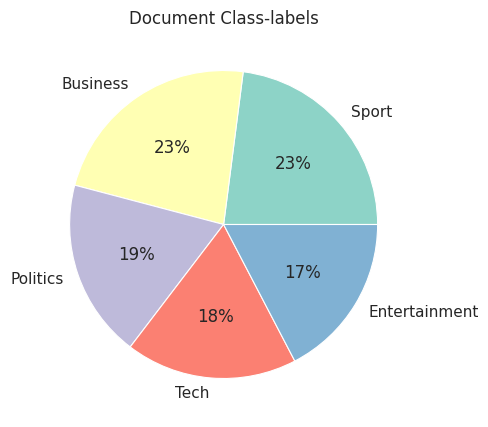

In [9]:
import matplotlib.pyplot as plt

# Calculate class counts
cls_count = meta_df["DocType"].value_counts()

# Create a pie chart with custom colors
colors = plt.cm.Set3.colors
plt.figure(figsize=(5, 5))
plt.pie(x=cls_count, labels=cls_count.index, autopct="%1.0f%%", colors=colors)

# Add a title
plt.title("Document Class-labels")

# Display the pie chart
plt.show()


#### Remarks

The dataset displays a uniform distribution among its classes, showing minimal discrepancies and a well-maintained balance across categories.

### 3.2 Class-label added, encoded DocType: `DocCat`

In [10]:
# Encode class labels
encoded_labels, unique_labels = pd.factorize(meta_df["DocType"])

# Create a mapping from encoded values to original class labels
class_label_mapping = dict(enumerate(unique_labels.categories))

# Display the encoded class labels and their mapping
print("Encoded class-labels:\n", class_label_mapping)

# Add a new column "DocCat" with the encoded values to the DataFrame
meta_df["DocCat"] = encoded_labels

# Display the count of each encoded value in the "DocCat" column
encoded_value_counts = meta_df["DocCat"].value_counts().sort_index()
print("Encoded value counts:\n", encoded_value_counts)


Encoded class-labels:
 {0: 'Business', 1: 'Entertainment', 2: 'Politics', 3: 'Sport', 4: 'Tech'}
Encoded value counts:
 DocCat
0    417
1    511
2    401
3    386
4    510
Name: count, dtype: int64


### 3.3 Class-label: `Filesize`

Text(0, 0.5, 'Document Type')

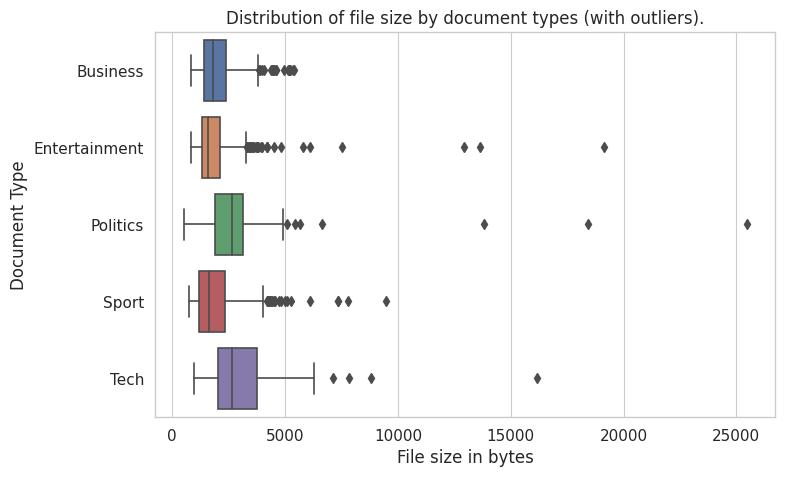

In [11]:
plt.figure(figsize=(8,5))
sns.boxplot(data=meta_df, x="FileSize", y="DocType")
plt.title("Distribution of file size by document types (with outliers).")
plt.xlabel("File size in bytes")
plt.ylabel("Document Type")

#### Remarks

The feature "FileSize" exhibits a significant skewness in its distribution and appears to contain a substantial number of data points that deviate significantly from the overall pattern, commonly referred to as outliers.

#### Identify outliers in the dataset using the Elbow method

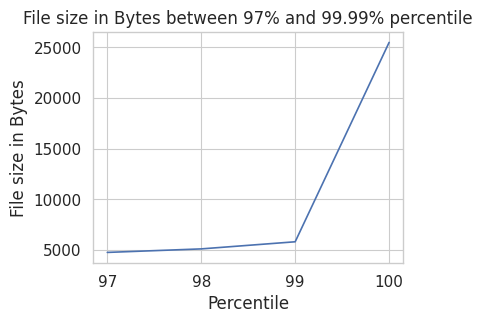

In [12]:
plot_percentile_range(97, 100, "FileSize", meta_df, "File size in Bytes")

#### Remarks

* The overwhelming majority of documents, approximately 99%, possess a file size below the threshold of approximately 6 KB.
* Documents exceeding this size can be regarded as exceptional cases or outliers within the dataset.

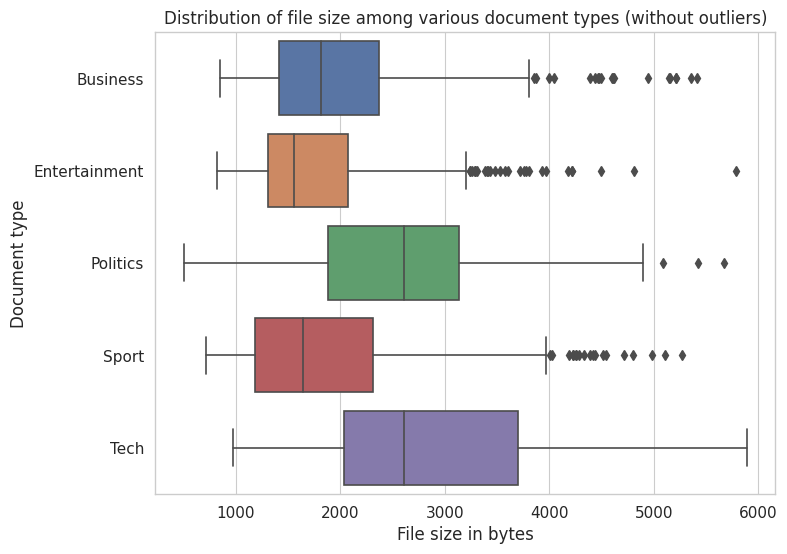

In [13]:
file_size_filter = meta_df["FileSize"] <6000
plt.figure(figsize=(8,6))

sns.boxplot(data=meta_df[file_size_filter], x="FileSize", y="DocType")

plt.title("Distribution of file size among various document types (without outliers)")
plt.xlabel("File size in bytes")
plt.ylabel("Document type")

plt.show()

In [14]:
percentage_above_6KB = (meta_df["FileSize"]>= 6000).mean() * 100
print(f"{percentage_above_6KB:.1f}% of documents have a size greater than 6KB. ")

0.9% of documents have a size greater than 6KB. 


Observations:


- Interestingly, documents in the "tech" and "politics" categories tend to have larger file sizes compared to other types, suggesting there might be something unique about them.

- Only a tiny 0.9% of documents have unusually large sizes (above 6 KB), and these could be removed later as they're outliers.

- Most document types share similar file size ranges, making it hard to tell them apart just by size.

- Looking only at file size doesn't show a clear pattern for identifying different document types.



## 4 Data Cleaning

1. The first step focuses on storing the raw text content of the documents in a compressed CSV filedocs_stage_2_parsed_text.csv. 
 
2. The second step involves extracting and counting language elements from the parsed content, saving the results into another CSV file docs_stage_3_preprocessed for further analysis.

* extracting language elements like lemmas, entities 
* Pars-Of-speech (POS) for count


### 4.1 Remove outliers

In [15]:
outlier_filter = meta_df["FileSize"]>6000
outliers_per_class = meta_df.loc[outlier_filter, "DocType"].value_counts()

percentage_data_lost = (outliers_per_class / cls_count) * 100
percentage_data_lost = percentage_data_lost.round(1)

table_data = list(zip(cls_count.index, percentage_data_lost)) # creates a list of tuples by zipping together the class labels and their corresponding percentages of data lost. 
headers = ["Class label", "% of data lost per class"]

#Each tuple represents a row in the table. This likely indicates whether to include a serial number (sl_no) in the table. 
print("+------------+--------------------------------------------+")
print("| Sl No.     | Class label     | % of data lost per class |")
print("+------------+--------------------------------------------+")

for i, (label, percent) in enumerate(table_data, start=1): # enumerate for get the tuple (label, percent) from each element in table_data
    print(f"| {i:<10} | {label:<15} | {percent:<24}% |") #Prints the serial number (i) left-aligned in a column of width 10.

print("+------------+--------------------------------------------+")

+------------+--------------------------------------------+
| Sl No.     | Class label     | % of data lost per class |
+------------+--------------------------------------------+
| 1          | Sport           | 0.0                     % |
| 2          | Business        | 1.3                     % |
| 3          | Politics        | 1.0                     % |
| 4          | Tech            | 1.0                     % |
| 5          | Entertainment   | 1.5                     % |
+------------+--------------------------------------------+


In [16]:
file_size_filter = meta_df["FileSize"] <= 6000
meta_df=meta_df[file_size_filter]
rows_wo, cols_wo =meta_df.shape
print(f"Dataset contains {rows_wo} rows and {cols_wo} columns after removing outliers.")

Dataset contains 2205 rows and 5 columns after removing outliers.


### 4.2 Text extraction and Cleanup

In [17]:
def preprocess_v2(text):
    # Normalize Unicode characters
    normalized_text = unicodedata.normalize('NFKD', text)

    # Remove special characters except for alphanumeric and spaces
    cleaned_text = re.sub(r"[^a-zA-Z0-9\s]", " ", normalized_text)

    # Compress consecutive spaces into a single space
    cleaned_text = re.sub(r"\s+", " ", cleaned_text).strip()

    return cleaned_text

#### Test Preprocessing

In [18]:
inp_text_2 = """
Hello there! How are you doing today?

I hope you enjoy testing this text preprocessing function.

Let's see how it handles various symbols: @#$%^&*()

And numbers: 12345

Does it work well with dates? 12/31/2023

Feel free to add more text and test it out!
"""

print(preprocess_v2(inp_text_2))


Hello there How are you doing today I hope you enjoy testing this text preprocessing function Let s see how it handles various symbols And numbers 12345 Does it work well with dates 12 31 2023 Feel free to add more text and test it out


#### Parse text from document fileS

In [19]:
# PARSED_TEXT_CSV = "parsed_text.csv"  # Assuming this is the destination CSV file path

def load_or_parse_text(doc_id, file_path):
    with open(file_path, "rb") as txt_f:
        ip_text = txt_f.read().decode("utf-8", errors="ignore").strip()

        # Check if the text is empty or contains only whitespace
        if not ip_text or ip_text.isspace():
            return None

        op_text = preprocess_v2(ip_text)
        return [doc_id, len(op_text), op_text]


# Check if the parsed text CSV file exists
if os.path.exists(PARSED_TEXT_CSV):
    print("Loading parsed text data of documents from:", PARSED_TEXT_CSV)
    prsd_df = pd.read_csv(PARSED_TEXT_CSV)
else:
    # Use list comprehension to process each document
    parsed_data = [
        load_or_parse_text(doc_id, file_path)
        for doc_id, file_path in tqdm(meta_df[["DocId", "FilePath"]].values)
    ]

    # Filter out None values (documents that were empty after preprocessing)
    parsed_data = [item for item in parsed_data if item is not None]

    # Convert parsed text from documents into a DataFrame
    col_names = ["DocId", "DocTextlen", "DocText"]
    prsd_df = pd.DataFrame(parsed_data, columns=col_names)

    # Save DataFrame as CSV file for future use
    prsd_df.to_csv(PARSED_TEXT_CSV, index=False, na_rep="")
    print("Parsed text saved to:", PARSED_TEXT_CSV)

prsd_df.head()


100%|██████████| 2205/2205 [00:17<00:00, 123.00it/s]


Parsed text saved to: /kaggle/working/docs_stage_2_parsed_text.csv


,DocId,DocTextlen,DocText
0,P_361,3037,Budget to set scene for election Gordon Brown ...
1,P_245,2964,Army chiefs in regiments decision Military chi...
2,P_141,3069,Howard denies split over ID cards Michael Howa...
3,P_372,3008,Observers to monitor UK election Ministers wil...
4,P_333,2529,Kilroy names election seat target Ex chat show...


## 5 NLP Preprocessing

1. **Lemmatization in spaCy handles decontraction:**
   
   Lemmatization is a linguistic process that involves reducing words to their base or root form. In the context of natural language processing (NLP), lemmatization is used to normalize words so that different inflections or variations of a word are represented by a common base form. Decontraction is a related concept that involves expanding contracted forms of words, such as "can't" to "cannot."

   While lemmatization alone does not always handle decontraction (expanding contractions), spaCy includes rules for decontraction during its lemmatization process. This means that contractions like "can't" may be expanded to "cannot" as part of the lemmatization process in spaCy.

2. **NER (Named Entity Recognition) is used to identify person or place names:**

   Named Entity Recognition (NER) is a task in natural language processing that involves identifying and classifying named entities in text into predefined categories such as person names, organization names, locations (places), dates, and more. In the context of your statement, NER can be used specifically to identify and classify instances of person names or place names within a given text.

   For example, if you have the sentence "John visited New York last week," NER would identify "John" as a person name and "New York" as a location or place name. NER is a valuable tool in various NLP applications, including information extraction, question answering, and text summarization, as it helps in identifying and understanding specific entities mentioned in the text.

### 5.1 Load English language Model

In [20]:
import spacy

# Load English language pipeline.
nlp = spacy.load("en_core_web_sm")

nlp.pipe_names

# from spellchecker import SpellChecker
# # Add spell checker to nlp pipeline.
# spell = SpellChecker()

# # Define a custom function to perform spell checking on the text
# def spell_check(text):
#     # Tokenize the text using spaCy
#     tokens = nlp(text)

#     # Get the original tokens as a list
#     original_tokens = [token.text for token in tokens]

#     # Perform spell checking on the original tokens
#     corrected_tokens = [spell.correction(token) for token in original_tokens]

#     # Combine the corrected tokens back into a string
#     corrected_text = " ".join(corrected_tokens)

#     return corrected_text

# # Example usage
# text_to_check = "Thiss is an example sentence witht some speling mistakes."
# corrected_text = spell_check(text_to_check)

# print("Original Text:", text_to_check)
# print("Corrected Text:", corrected_text)


['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

<img src="https://spacy.io/images/pipeline.svg" />
<br>
<center align="center">
    Image source:
    <a href="https://spacy.io/usage/processing-pipelines">spacy.io</a>
</center>

### 5.2 Function to process language

Separated the decontraction, lemmatization and filtering, and POS count capture into individual functions. 
This can make the code more modular and easier to understand. 
Also, the decontraction patterns can be passed as a parameter for more flexibility. 

In [21]:
def decontract_text(doc, patterns):
    # Special cases of decontraction.
    atrib_rlr = nlp.get_pipe("attribute_ruler")
    atrib_rlr.add_patterns(patterns)

    return doc

def lemmatize_and_filter(doc, rm_stp=True, rm_pun=True):
    lemmas = [
    tkn.lemma_.strip().lower()  # Get the lemmatized form of the token, remove leading/trailing whitespaces, and convert to lowercase
    for tkn in doc  # Iterate over each token in the processed document
    if not (rm_stp and tkn.is_stop)  # If remove stop words is True and the token is a stop word, skip the token
    and not (rm_pun and tkn.is_punct)  # If remove punctuation is True and the token is punctuation, skip the token
]

    return " ".join(lemmas)

def capture_pos_count(doc, Id=None):
    # Initialize a dictionary for capturing part-of-speech counts. Include "DocId" if Id is provided.
    pos_count = {"DocId": Id} if Id else {}
    # Iterate over sorted part-of-speech counts (items) in the document.
    for item in sorted(doc.count_by(spacy.attrs.POS).items(), key=lambda i: i[0]):
        # Convert the integer POS label to its corresponding text representation.
        pos_label = doc.vocab[item[0]].text
        # Assign the count of occurrences to the dictionary with the POS label as the key.
        pos_count[pos_label] = item[1]
    # Return the dictionary containing part-of-speech counts.
    return pos_count


def process_language(Id, text, rm_stp=True, rm_pun=True, decontraction_patterns=None):
    """
    Function to process language by
        1. Removing stop-words and punctuation marks.
        2. Lemmatizing tokens.
        3. Chunking entities.
    """
    doc = nlp(str(text))

    if decontraction_patterns:
        doc = decontract_text(doc, decontraction_patterns)

    lmtzd_txt = lemmatize_and_filter(doc, rm_stp, rm_pun)
    pos_count = capture_pos_count(doc, Id)

    return lmtzd_txt, pos_count


#### Test language processing


To demonstrate the language processing function, we have configured the following conditions:

1. **Stop Words:** By default, the language processing function removes stop words. However, for this demonstration, we have chosen not to remove stop words.

2. **Minimum String Length:** The default minimum string length allowed during processing is 3 characters. Nevertheless, for the purpose of this demonstration, we have set the minimum string length to zero.

These conditions are selected to showcase specific aspects of the language processing function. Stop words will be retained, and there is no minimum length requirement for strings during the processing of the provided texts."

In [22]:
texts = [
    "The sun sets behind the mountains, painting the sky in hues of orange and pink.",
    "Coding is an art, and every programmer is a storyteller.",
    "Exploring the vast universe, astronomers discover new galaxies and phenomena.",
    "In a bustling city, people rush to catch the morning train, each with a story of their own.",
    "Music transcends language, evoking emotions that words cannot express.",
    "A chef meticulously crafts a dish, blending flavors to create a culinary masterpiece.",
    "In the heart of the forest, a stream gently flows, whispering secrets to the ancient trees.",
]

for text in texts:
    # `process_language()` with spell-check enabled and stop-words retained.
    lmtzd_txt, pos_count = process_language(None, text, rm_stp=False, rm_pun=True)

    print("Original:\n", text)
    print("\nLemmatized text:\n", lmtzd_txt)
    print("\nPOS count:\n", pos_count)
    print("\n" + "="*50 + "\n")  # Separator line


Original:
 The sun sets behind the mountains, painting the sky in hues of orange and pink.

Lemmatized text:
 the sun set behind the mountain paint the sky in hue of orange and pink

POS count:
 {'ADJ': 1, 'ADP': 3, 'CCONJ': 1, 'DET': 3, 'NOUN': 5, 'PUNCT': 2, 'VERB': 2}


Original:
 Coding is an art, and every programmer is a storyteller.

Lemmatized text:
 code be an art and every programmer be a storyteller

POS count:
 {'AUX': 2, 'CCONJ': 1, 'DET': 3, 'NOUN': 3, 'PUNCT': 2, 'VERB': 1}


Original:
 Exploring the vast universe, astronomers discover new galaxies and phenomena.

Lemmatized text:
 explore the vast universe astronomer discover new galaxy and phenomenon

POS count:
 {'ADJ': 2, 'CCONJ': 1, 'DET': 1, 'NOUN': 4, 'PUNCT': 2, 'VERB': 2}


Original:
 In a bustling city, people rush to catch the morning train, each with a story of their own.

Lemmatized text:
 in a bustling city people rush to catch the morning train each with a story of their own

POS count:
 {'ADJ': 2, 'ADP': 

### 5.3 Decontraction, Lemmatization and NER

In [23]:
# Assuming FINAL_CSV is the path to the final CSV file
FINAL_CSV = "/kaggle/working/final.csv"

# Check if the final CSV file already exists
if os.path.exists(FINAL_CSV):
    print("Loading language preprocessed text data from:", FINAL_CSV)
    final_df = pd.read_csv(FINAL_CSV)
else:
    # Fork prsd_df DataFrame.
    lang_df = prsd_df.copy()

    # Process each document in lang_df
    lmtzd_txts = []
    pos_counts = []
    for doc_id, doc_text in tqdm(lang_df[["DocId", "DocText"]].values):
        # Perform decontraction, lemmatization, and NER on each row.
        lmtzd_txt, pos_count = process_language(doc_id, doc_text)
        lmtzd_txts.append(lmtzd_txt)
        pos_counts.append(pos_count)

    # Update the 'DocText' column in lang_df with lemmatized texts
    lang_df["DocText"] = lmtzd_txts

    # Create a DataFrame for parts-of-speech counts
    pos_df = pd.DataFrame(pos_counts).fillna(0)

    # Merge DataFrames: lang_df, pos_df, and meta_df
    final_df = lang_df.merge(pos_df, on="DocId").merge(meta_df, on="DocId")

    # Save final DataFrame as a CSV file.
    final_df.to_csv(FINAL_CSV, index=False, na_rep="")

# Display the first 2 rows of the final DataFrame
final_df.head(2)


100%|██████████| 2205/2205 [02:54<00:00, 12.65it/s]


,DocId,DocTextlen,DocText,ADJ,ADP,ADV,AUX,CCONJ,DET,NOUN,...,SCONJ,VERB,INTJ,X,PUNCT,SYM,DocType,FileSize,FilePath,DocCat
0,P_361,3037,budget set scene election gordon brown seek ec...,40,61,16.0,29.0,12.0,61,140,...,10.0,66,0.0,0.0,0.0,0.0,Politics,3132,/kaggle/input/bbc-full-text-document-classific...,0
1,P_245,2964,army chief regiment decision military chief ex...,38,58,14.0,31.0,22.0,69,96,...,6.0,64,0.0,0.0,0.0,0.0,Politics,3018,/kaggle/input/bbc-full-text-document-classific...,0


## 6 EDA 

### 6.1 The conclusive form of the dataset 

In [25]:
rows, cols = final_df.shape
print(f"Dataset contains {rows} rows and {cols} columns.\n")
      
meta_df.info()

Dataset contains 2205 rows and 24 columns.

<class 'pandas.core.frame.DataFrame'>
Index: 2205 entries, 0 to 2224
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   DocType   2205 non-null   category
 1   DocId     2205 non-null   object  
 2   FileSize  2205 non-null   int64   
 3   FilePath  2205 non-null   object  
 4   DocCat    2205 non-null   int64   
dtypes: category(1), int64(2), object(2)
memory usage: 88.5+ KB


### 6.2 Correlation matrix

In [40]:
def get_corr_mat(df, target):
    """
    Function to return:
        1. Correlation matrix sorted by target value in descending order.
        2. Variance of random variables reset to zero.
    """
    # Select only numeric columns for correlation calculation
    numeric_df = df.select_dtypes(include=[np.number])

    # Check if there are any numeric columns
    if numeric_df.empty:
        raise ValueError("No numeric columns in the DataFrame.")

    # Calculate the correlation matrix
    corr_mat = numeric_df.corr()

    # Reset the diagonal elements (variance) to zero
    np.fill_diagonal(corr_mat.values, 0)

    # Sort the correlation matrix by the target variable in descending order
    sorted_corr_mat = corr_mat[target].sort_values(ascending=False)

    return sorted_corr_mat

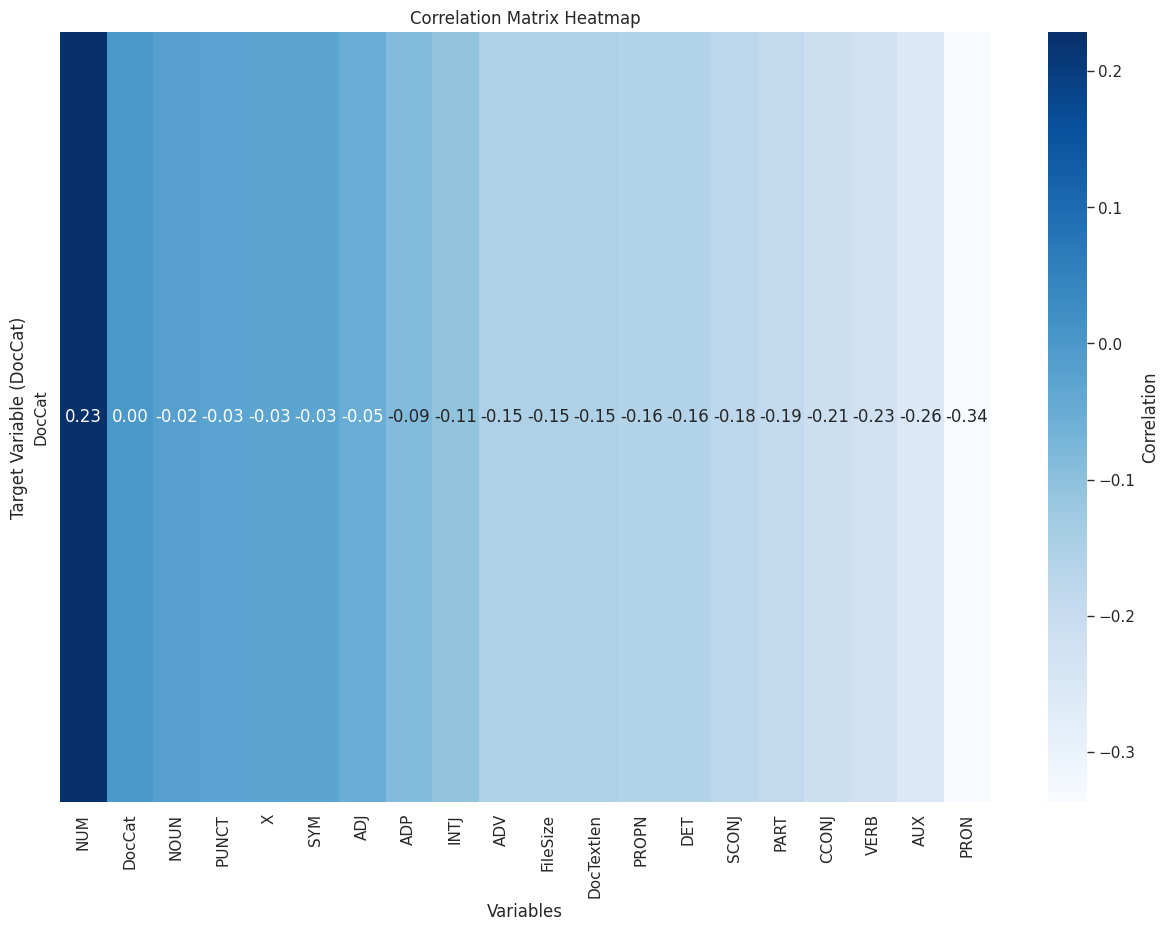

In [43]:
# Get the correlation matrix
corr_mat = get_corr_mat(final_df, "DocCat")

# Create a heatmap using seaborn
plt.figure(figsize=(15, 10))
sns.heatmap(corr_mat.to_frame().T, cmap="Blues", annot=True, fmt=".2f", cbar_kws={'label': 'Correlation'})
plt.title("Correlation Matrix Heatmap")
plt.xlabel("Variables")
plt.ylabel("Target Variable (DocCat)")

# Display the plot
plt.show()

In [42]:
final_df

,DocId,DocTextlen,DocText,ADJ,ADP,ADV,AUX,CCONJ,DET,NOUN,...,SCONJ,VERB,INTJ,X,PUNCT,SYM,DocType,FileSize,FilePath,DocCat
0,P_361,3037,budget set scene election gordon brown seek ec...,40,61,16.0,29.0,12.0,61,140,...,10.0,66,0.0,0.0,0.0,0.0,Politics,3132,/kaggle/input/bbc-full-text-document-classific...,0
1,P_245,2964,army chief regiment decision military chief ex...,38,58,14.0,31.0,22.0,69,96,...,6.0,64,0.0,0.0,0.0,0.0,Politics,3018,/kaggle/input/bbc-full-text-document-classific...,0
2,P_141,3069,howard deny split id card michael howard deny ...,30,43,12.0,47.0,14.0,51,109,...,15.0,93,0.0,0.0,0.0,0.0,Politics,3153,/kaggle/input/bbc-full-text-document-classific...,0
3,P_372,3008,observer monitor uk election ministers invite ...,42,62,16.0,32.0,11.0,42,108,...,10.0,74,0.0,0.0,0.0,0.0,Politics,3082,/kaggle/input/bbc-full-text-document-classific...,0
4,P_333,2529,kilroy name election seat target ex chat host ...,35,50,9.0,26.0,7.0,40,84,...,6.0,54,1.0,0.0,0.0,0.0,Politics,2604,/kaggle/input/bbc-full-text-document-classific...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,B_380,1392,india open sky competition india allow domesti...,25,15,12.0,21.0,9.0,10,47,...,4.0,36,0.0,0.0,0.0,0.0,Business,1425,/kaggle/input/bbc-full-text-document-classific...,4
2201,B_192,2230,yukos bankruptcy matter russian authority abid...,25,45,6.0,25.0,12.0,34,81,...,6.0,54,0.0,0.0,0.0,0.0,Business,2281,/kaggle/input/bbc-full-text-document-classific...,4
2202,B_248,1830,survey confirm property slowdown government fi...,21,68,10.0,14.0,6.0,41,77,...,4.0,28,0.0,0.0,0.0,0.0,Business,1875,/kaggle/input/bbc-full-text-document-classific...,4
2203,B_004,2314,high fuel price hit ba s profit british airway...,34,51,17.0,17.0,8.0,27,107,...,8.0,45,0.0,0.0,0.0,0.0,Business,2412,/kaggle/input/bbc-full-text-document-classific...,4


### 